# Introduction to RNN and prediction of TimeSeries data

TimeSeries data has very distinct features

- Temporal component. Basic assumptions of independent data points don’t hold true
- Trend: Determinitic or Stochastic
- Seasonality: pattern that reflects periodicity or fluctuations


#### Additional TimeSeries Datasets
https://machinelearningmastery.com/time-series-datasets-for-machine-learning/

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import mxnet as mx
from sklearn.preprocessing import MinMaxScaler

C:\Users\Gourab\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


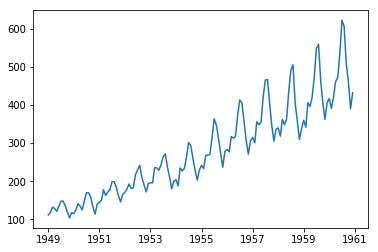

Month
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
1949-06-01    4.905275
1949-07-01    4.997212
1949-08-01    4.997212
1949-09-01    4.912655
1949-10-01    4.779123
Name: #Passengers, dtype: float64


In [2]:
%matplotlib inline

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('../data/AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
print(data.head())

ts = data['#Passengers'] 
plt.plot(ts)
plt.show()
ts_log = np.log(ts)
print(ts_log[:10])

### Spot checking if TS is Stationary with Moving Average

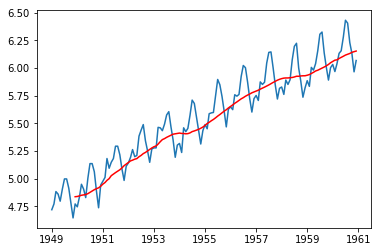

In [3]:
# moving average
moving_avg = ts_log.rolling(window=12, center=False).mean()
rolstd = ts_log.rolling(window=12, center=False).std()

plt.plot(ts_log)
plt.plot(moving_avg, color='red')
#plt.plot(rolstd, color='black', label= Rolling Std')
#plt.legend(loc='best')
plt.show()

### Lets explore differencing the series to make it stationary

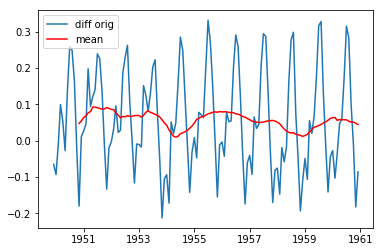

In [4]:
# Subtract rolling mean

ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)

moving_avg = ts_log_moving_avg_diff.rolling(window=12, center=False).mean()
rolstd = ts_log_moving_avg_diff.rolling(window=12, center=False).std()

plt.plot(ts_log_moving_avg_diff, label="diff orig")
plt.plot(moving_avg, color='red', label='mean')
plt.legend(loc='best')
plt.show()

In [5]:
### EXPONENTIAL SMOOTHING

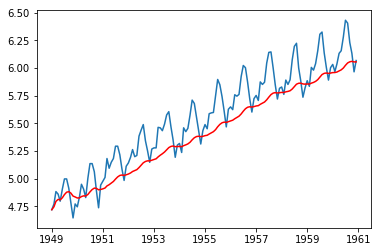

In [6]:
expwighted_avg = ts_log.ewm(halflife=12,ignore_na=False,min_periods=0,adjust=True).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

### Switching Gears -- ARIMA Forecasting

Lets now work with a simple shampoo sales dataset

C:\Users\Gourab\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\Gourab\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1333: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\Gourab\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1336: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full

predicted=330.488078, expected=355.000000
predicted=368.172547, expected=422.000000
predicted=417.317456, expected=465.000000
predicted=468.888417, expected=467.000000
predicted=462.688177, expected=404.000000
predicted=368.300096, expected=347.000000
predicted=340.324466, expected=305.000000
predicted=308.878317, expected=336.000000
predicted=383.349024, expected=340.000000
predicted=351.781299, expected=318.000000
predicted=322.739357, expected=362.000000
predicted=372.884452, expected=348.000000
predicted=333.332458, expected=363.000000
predicted=382.493467, expected=435.000000
predicted=435.787755, expected=491.000000
predicted=502.006291, expected=505.000000
predicted=497.701941, expected=404.000000
predicted=347.130160, expected=359.000000
predicted=364.777336, expected=310.000000
predicted=307.297480, expected=337.000000
predicted=394.595006, expected=360.000000
predicted=377.731212, expected=342.000000
predicted=343.945925, expected=406.000000
predicted=419.248008, expected=396

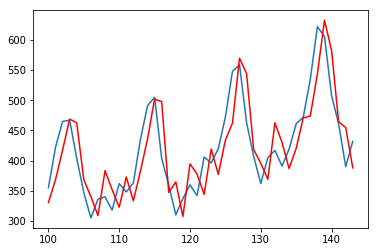

In [7]:
#https://datamarket.com/data/set/22r0/sales-of-shampoo-over-a-three-year-period

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# series = pd.read_csv('../data/AirPassengers.csv', header=0, index_col=0, squeeze=True)
series = pd.read_csv('../data/AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)

X = series.values
ticks = range(len(X))

size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]

history = [float(x) for x in train[:size]]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot
plt.plot(ticks[-len(test):], test)
plt.plot(ticks[-len(test):], predictions, color='red', label='cosine')
plt.show()

### RNN model using Mxnet

In [51]:
## Data loader
dataset = series.values
ticks = range(len(dataset))

## Data scaling
dataset = np.reshape(dataset, (len(dataset), 1))
scaler = MinMaxScaler(feature_range=(0,1))
scaled_dataset = scaler.fit_transform(dataset)

print(type(scaled_dataset))

## Sequence creating using timesteps as 3
seq_len = 3
x = scaled_dataset
y = scaled_dataset[: ,[-1]]

dataX = []; dataY = []

for i in range(0, len(y)-seq_len):
    _x = x[i: i+seq_len]
    _y = y[i+seq_len]
    dataX.append(_x)
    dataY.append(_y)
    
## train test split(70:30)
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) -  train_size

batch_size = 8

## getting the train and test dataset using mxnet NDArray
trainX, testX = np.array(dataX[:train_size]), np.array(dataX[train_size:])
trainY, testY = np.array(dataY[:train_size]), np.array(dataY[train_size:])

train_data=[]
for index,data in enumerate(trainX):
    temp = trainY[index]
    train_data.append((data,temp))
    
test_data = []
for index,data in enumerate(testX):
    temp = testY[index]
    test_data.append((data,temp))

    
train_data  = mx.gluon.data.DataLoader(train_data, batch_size,shuffle = True)
test_data = mx.gluon.data.DataLoader(test_data, batch_size,shuffle = False)

# train_iter = mx.io.NDArrayIter(data=trainX, label=trainY, 
#                                batch_size=batch_size, shuffle=True)

# val_iter = mx.io.NDArrayIter(data=testX, label=testY, 
#                                batch_size=batch_size, shuffle=False)

<class 'numpy.ndarray'>


C:\Users\Gourab\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [36]:
def transform(data, label):
    return data.astype(np.float32), label.astype(np.float32)

### Model Building

In [ ]:
from mxnet import nd, autograd, gluon
loss_mse = gluon.loss.L1Loss()
model2 = mx.gluon.nn.Sequential()
ctx = mx.gpu() if mx.test_utils.list_gpus() else mx.cpu()
data_ctx = ctx
model_ctx = ctx


with model2.name_scope():
    model2.add(mx.gluon.rnn.RNN(128))
    model2.add(mx.gluon.nn.Dense(1, flatten=True))

model2.collect_params().initialize(mx.init.Normal(sigma=.05), ctx=model_ctx)

trainer = gluon.Trainer(model2.collect_params(), 'adam', {'learning_rate': .01})

network_1_train_loss = []
for e in range(150):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data , label = transform(data,label)
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)

        with autograd.record():
            output = model2(data)
            loss = loss_mse(output, label)
        loss.backward()
        trainer.step(data.shape[0])
        cumulative_loss += nd.sum(loss).asscalar()

    print(cumulative_loss)

In [149]:
cnt = 0
t_loss = 0
predict = np.array([])
for i, (data, label) in enumerate(test_data):
    data , label = transform(data,label)
    data = data.as_in_context(model_ctx)
    label = label.as_in_context(model_ctx)
    with autograd.record():
        output = model2(data)
        loss = mx.metric.MSE()
        loss.update(labels = label, preds = output)
        predict = np.concatenate((predict, output.asnumpy().flatten()))
        t_loss = t_loss + loss.get()[1]
        cnt = cnt + 1

print("Total loss: ", float(t_loss/cnt))

Total loss:  0.030061916448175907


MSE: 7384.085169137002


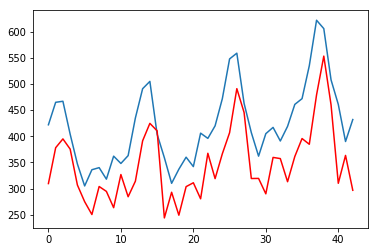

In [151]:
import matplotlib.pyplot as plt
%matplotlib inline


# test_pred = model1.predict(predict).asnumpy()
test_plot = scaler.inverse_transform(predict.reshape(-1,1))
test_original = scaler.inverse_transform(testY)

print("MSE:",np.mean((test_plot-test_original)**2))

# Plotting original vs predicted
plt.plot(test_original, label='original')
plt.plot(test_plot, color='red', label='predict')
plt.show()